# Antenna Position Calibration

Author: Tim Molteno. tim@elec.ac.nz.

The antennas are laid out on five spiral arms.  This notebook will use measurements to infer the actual layout of the antennas.

The other reference point is the center of the array. This is assumed to be the point [0,0]. Make sure that a marker is present at this reference point at the same height as the level of the antennas (otherwise the distances will be wrong).

In [1]:
import numpy as np
from scipy.optimize import minimize

# pip install numpy scipy pandas odfpy

In [2]:
site_name = 'nz-elec'
x0 = [0,0]
global_rot_degrees = +10.173
global_rot_index = 0

In [3]:
import pandas as pd

cols = [f"A {i}" for i in range(24)]
data = pd.read_excel('antenna_measurements.ods', "Sheet1", usecols=cols)
radius = data.loc[0]
radius

A 0      332.0
A 1      870.0
A 2     1210.0
A 3     1450.0
A 4     1645.0
A 5      335.0
A 6      872.0
A 7     1210.0
A 8     1452.0
A 9     1650.0
A 10     337.0
A 11     872.0
A 12    1214.0
A 13    1455.0
A 14    1650.0
A 15     337.0
A 16     872.0
A 17    1212.0
A 18    1455.0
A 19    1655.0
A 20     332.0
A 21     867.0
A 22    1210.0
A 23    1450.0
Name: 0, dtype: float64

## Finding the antennas

This is done by measuring the distance from each antenna to x0 as well as each other antenna. The distance $m_0$ are the measurements to $x_0$. The array m_ij are the distances between antennas.

In [4]:
n_ant = 24
m_0 = np.zeros(n_ant)
m_ij = np.zeros((n_ant,n_ant))

radius = data.loc[0]

for i in range(n_ant):
    m_ij[i,:] = data.loc[i+1]

The following are the measured distances from [x1, x0, x2] from the reference points in millimeters. Note that their order must be the same as the order of the variable called 'reference_points'. In this case, they are x1,x0,x2.

In [5]:
for i in range(n_ant):
    for j in range(n_ant):
        if not np.isnan(m_ij[i,j]):
            m_ij[j,i] = m_ij[i,j]

m_ij


array([[  nan,   nan,   nan,   nan, 1414.,   nan,   nan,   nan,   nan,
        1810.,   nan,   nan,   nan,   nan, 1986.,   nan,   nan,   nan,
          nan, 1760.,   nan,   nan,   nan, 1212.],
       [  nan,   nan,   nan,   nan, 1004.,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan, 2522.,   nan,   nan,   nan,
          nan, 2153.,   nan,   nan,   nan, 1120.],
       [  nan,   nan,   nan,   nan,  650.,   nan,   nan,   nan,   nan,
        2077.,   nan,   nan,   nan,   nan, 2836.,   nan,   nan,   nan,
          nan, 2543.,   nan,   nan,   nan, 1375.],
       [  nan,   nan,   nan,   nan,  323.,   nan,   nan,   nan,   nan,
        2036.,   nan,   nan,   nan,   nan, 3026.,   nan,   nan,   nan,
          nan, 2866.,   nan,   nan,   nan, 1695.],
       [1414., 1004.,  650.,  323.,   nan, 1374., 1153., 1328., 1622.,
        1944., 1759., 2153., 2544., 2867., 3142., 1987., 2522., 2836.,
        3025., 3142., 1807., 2026., 2070., 2017.],
       [  nan,   nan,   nan,   nan,

## Plot the Initial Guess Points

Initial Guesses are from JSON queried from the telescope API. These are converted to millimeters.

In [6]:
import json
import requests

def get_data(path):
    server = "https://api.elec.ac.nz/tart/zm-cbu/"

    r = requests.get('{}/{}'.format(server, path))
    return json.loads(r.text)

def get_pos():
    return np.array(get_data('api/v1/imaging/antenna_positions'))

if True:
    # with open('hammanskraal_antenna_positions_nonaligned.json', "r") as f:
    with open('antenna_positions.json', "r") as f:
        data = f.read()
    cal_json = json.loads(data)
    current_pos = cal_json["ant_pos"]
    current_pos = np.array(current_pos)
else:
    current_pos = get_pos()
    json_result = {}
    json_result["antenna_positions"] = current_pos.tolist()
    print(json.dumps(json_result, indent=4, separators=(',', ': ')))


In [7]:
def geo_angle(x,y):
    return 90 - np.degrees(np.arctan2(y,x))

geo_angle(1,0)

np.float64(90.0)

0 : 24.297791417833842,334.4784842338742, geo: 4.1548853566467585
1 : 213.71926230888775,844.0758184249547, geo: 14.208627642522075
2 : 516.8456754781338,1095.6349690995446, geo: 25.254734471213013
3 : 838.9968993937326,1186.1662475709518, geo: 35.27246204327492
4 : 1161.7307530146684,1171.0382410000295, geo: 44.77139744611332
5 : 325.61637246504023,80.25096302152869, geo: 76.15488535664676
6 : 868.8066914389415,57.5746753575925, geo: 86.20862764252209
7 : 1201.7248740349035,-152.97962249921977, geo: 97.25473447121303
8 : 1387.375439302275,-431.38793966645335, geo: 107.27246204327493
9 : 1472.7180955034303,-743.0008853031206, geo: 116.77139744611328
10 : 176.9441940590064,-284.8806614566585, geo: 148.15488535664676
11 : 323.23280265372046,-808.4927121627212, geo: 158.20862764252206
12 : 225.86114180162303,-1190.1815753901901, geo: 169.254734471213
13 : 18.448277251890204,-1452.7786566216087, geo: 179.2724620432749
14 : -251.54091414653467,-1630.2380417886209, geo: 188.77139744611333
15

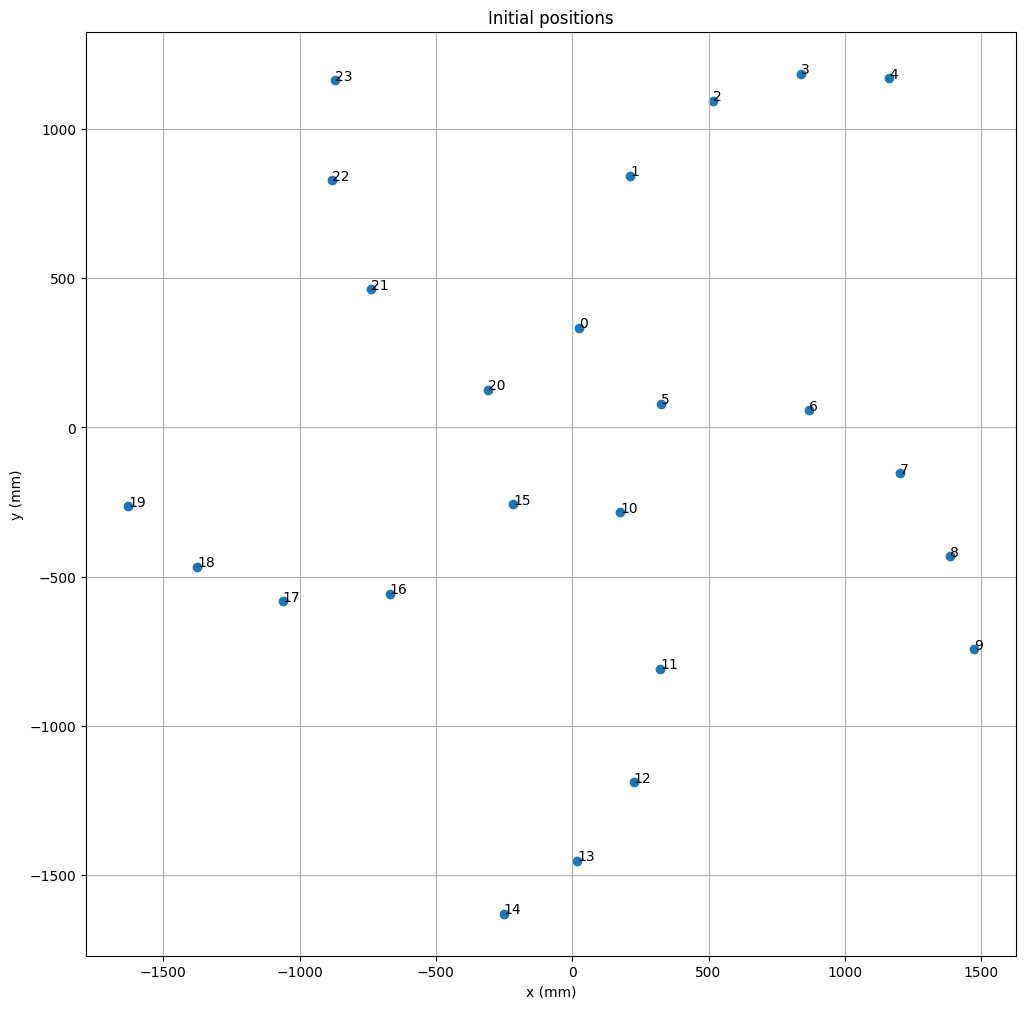

In [8]:
def i_y(i):
    return 2*i+1

def i_x(i):
    return 2*i


initial_guess = np.zeros(2*n_ant)

for i in range(n_ant):
    x,y = current_pos[i][0:2]*1000
    initial_guess[i_x(i)] = x
    initial_guess[i_y(i)] = y
    
    print(f"{i} : {x},{y}, geo: {geo_angle(x,y)}")

pos_i = initial_guess.reshape((24,2))
#pos_i = current_pos*1000

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(pos_i[:,0], pos_i[:,1])
for i in range(0,pos_i.shape[0]):
    ax.text(pos_i[i,0], pos_i[i,1],f"{i}")

ax.grid(True)
ax.set_title('Initial positions')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
plt.savefig('initial_positions.png')
plt.show()

## Criteria for Optimality

The function below is minimized when the positions (in variable x) are consistent with the measured distances m[i,j]. The initial value of this function is more than 3 million.

Note that the x input is a 1D vector of with 48 entries as [p0.x, p0.y, p1.x, p1.y]

In [9]:
def geo_angle(x,y):
    return 90 - np.degrees(np.arctan2(y,x))

geo_angle(1,0)

np.float64(90.0)

In [10]:
def dist(a,b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)


def p(x, i):
    return [x[i_x(i)],x[i_y(i)]]

max_err = 4200
def bounds():
    ret = [(0,0)]*48
    for i in range(n_ant):
        _x,_y = pos_i[i,0], pos_i[i,1]
        ret[i_x(i)] = (_x - max_err, _x + max_err)
        ret[i_y(i)] = (_y - max_err, _y + max_err)
    
    return ret

bnd = bounds()

center = [0,0]

def angle(x, i):
    _x, _y = p(x, i)
    return geo_angle(_x, _y)
    
def radius_model(x):
    ret = []
    
    for i in range(n_ant):
        p_i = p(x,i)
        ret.append(dist(center, p_i))
        
    return np.array(ret)

non_nan_ij = []
non_nan_indices = []
for i in range(n_ant):
    for j in range(n_ant):
        if not np.isnan(m_ij[i,j]):
            non_nan_ij.append(m_ij[i,j])
            non_nan_indices.append([i,j])
non_nan_ij = np.array(non_nan_ij)
non_nan_indices = np.array(non_nan_indices)

def m_ij_model(x):
    ret = []
    for i in range(n_ant):
        p_i = p(x,i)

        for j in range(n_ant):
            p_j = p(x,j)
            if not np.isnan(m_ij[i,j]):
                ret.append(dist(p_j, p_i))
                
    return np.array(ret)
    
def radius_residual(x):
    predict = radius_model(x)
    return (predict - radius)

def m_ij_residual(x):
    predict = m_ij_model(x)
    return (predict - non_nan_ij)

def rot_residual(x):
    predict = angle(x, global_rot_index)
    return (predict - global_rot_degrees)

def f_old(x):
    ret = 0
    for i in range(n_ant):
        p_i = p(x,i)
        ret += (dist(center, p_i) - m_0[i])**2
        for j in range(n_ant):
            p_j = p(x,j)
            if not np.isnan(m_ij[i,j]):
                ret += (dist(p_j, p_i) - m_ij[i,j])**2
    return ret

def f(x):
    # This is the final criterion for optimality. The sum of squared residuals.
    ret = np.sum(radius_residual(x)**2)*10
    ret += np.sum(m_ij_residual(x)**2)
    ret += (rot_residual(x)**2)*100
    return ret


In [11]:
print(f(initial_guess))

9379.052257616178


 We can see that the initial value of this optimality condition is quite large.s

In [12]:
res = minimize(f, initial_guess, bounds=None, options={'maxiter': 500})
res

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1204.8440340367472
        x: [ 5.880e+01  3.277e+02 ... -7.212e+02  1.259e+03]
      nit: 93
      jac: [ 1.678e-04  9.155e-05 ...  6.409e-04  1.678e-04]
 hess_inv: [[ 4.508e-02 -4.945e-03 ... -3.513e-04  1.093e-03]
            [-4.945e-03  2.911e-02 ... -4.862e-04 -1.107e-03]
            ...
            [-3.513e-04 -4.862e-04 ...  5.492e-03 -2.977e-04]
            [ 1.093e-03 -1.107e-03 ... -2.977e-04  5.701e-03]]
     nfev: 8881
     njev: 181

In [13]:
err = res.jac.reshape((24,2))
rms = err # np.sqrt(np.sum(err**2, axis=1))
for i in range(24):
    print(f"Ant {i}:\tJac: {rms[i,0]:06.2f}, \t{rms[i,1]:06.2f}")

Ant 0:	Jac: 000.00, 	000.00
Ant 1:	Jac: 000.00, 	000.00
Ant 2:	Jac: -00.00, 	000.00
Ant 3:	Jac: 000.00, 	000.00
Ant 4:	Jac: 000.00, 	000.00
Ant 5:	Jac: 000.00, 	000.00
Ant 6:	Jac: -00.00, 	-00.00
Ant 7:	Jac: -00.00, 	-00.00
Ant 8:	Jac: 000.00, 	000.00
Ant 9:	Jac: 000.00, 	000.00
Ant 10:	Jac: 000.00, 	000.00
Ant 11:	Jac: 000.00, 	000.00
Ant 12:	Jac: 000.00, 	000.00
Ant 13:	Jac: 000.00, 	-00.00
Ant 14:	Jac: 000.00, 	000.00
Ant 15:	Jac: -00.00, 	-00.00
Ant 16:	Jac: 000.00, 	-00.00
Ant 17:	Jac: 000.00, 	000.00
Ant 18:	Jac: 000.00, 	000.00
Ant 19:	Jac: -00.00, 	-00.00
Ant 20:	Jac: 000.00, 	000.00
Ant 21:	Jac: -00.00, 	-00.00
Ant 22:	Jac: -00.00, 	-00.00
Ant 23:	Jac: 000.00, 	000.00


The optimized positions are now known. The final value of the function is 32. Far closer to zero than 3 million!

We can recover the x,y coordinates by reshaping the array

In [14]:
pos = res.x.reshape((24,2))
pos

array([[   58.80477099,   327.70993725],
       [  306.62401255,   814.42985315],
       [  636.04241629,  1029.50710566],
       [  966.19756871,  1082.41334307],
       [ 1286.56525679,  1030.90407925],
       [  332.60851531,    42.50820137],
       [  870.7870182 ,   -44.44029956],
       [ 1174.26730138,  -291.01246933],
       [ 1327.83382947,  -590.98248807],
       [ 1377.63350694,  -911.46194688],
       [  143.4636414 ,  -305.51487132],
       [  226.89042678,  -842.95353479],
       [   85.68319523, -1211.37037574],
       [ -150.95660888, -1448.35661032],
       [ -441.70925647, -1592.88779475],
       [ -245.19851072,  -232.1775151 ],
       [ -729.41054314,  -479.44156375],
       [-1122.48740116,  -460.13673888],
       [-1422.28284368,  -308.13542353],
       [-1651.35786009,   -79.66904944],
       [ -294.06475855,   160.07452441],
       [ -676.64852692,   545.46891916],
       [ -778.03944356,   928.05471152],
       [ -721.18628517,  1259.28829603]])

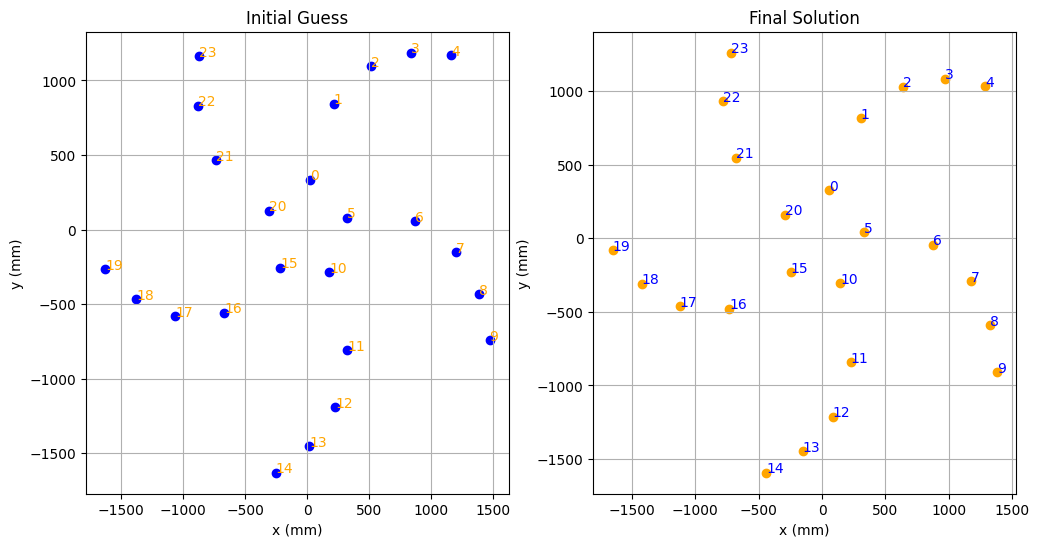

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))


ax[0].scatter(pos_i[:,0], pos_i[:,1], label='initial', color='blue')
for i in range(0,pos_i.shape[0]):
    ax[0].text(pos_i[i,0], pos_i[i,1],f"{i}", color='orange')
ax[0].set_title('Initial Guess')
ax[0].grid(True)
ax[0].set_xlabel('x (mm)')
ax[0].set_ylabel('y (mm)')

ax[1].scatter(pos[:,0], pos[:,1], label='final', color='orange')
for i in range(0,pos.shape[0]):
    ax[1].text(pos[i,0], pos[i,1],f"{i}", color='blue')
ax[1].set_title('Final Solution')
ax[1].grid(True)
ax[1].set_xlabel('x (mm)')
ax[1].set_ylabel('y (mm)')
plt.savefig('final_positions.png')
plt.show()

![title](drone_view.jpeg)

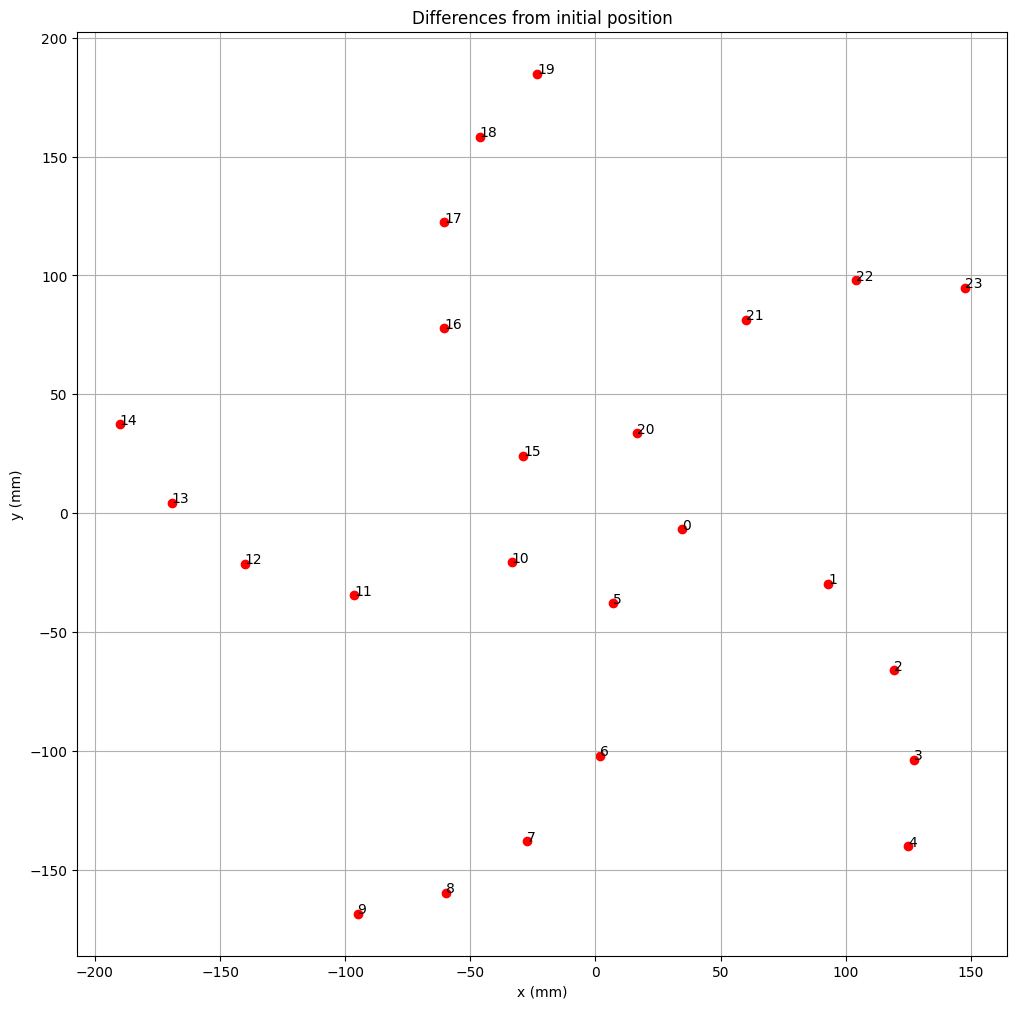

In [16]:
# Differences plot
diff = pos - pos_i[:,0:2]


fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(diff[:,0], diff[:,1], color='red')

for i in range(0,diff.shape[0]):
    ax.text(diff[i,0], diff[i,1],f"{i}")

ax.grid(True)
ax.set_title("Differences from initial position")
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
plt.savefig('differences.png')
plt.show()

In [17]:
# Residual plot
rres = radius_residual(res.x)
rres

A 0     0.944146
A 1     0.238054
A 2     0.138354
A 3     0.915706
A 4     3.639858
A 5     0.313841
A 6    -0.079722
A 7    -0.209955
A 8     1.410809
A 9     1.858638
A 10    0.522078
A 11    0.954711
A 12    0.396886
A 13    1.202173
A 14    2.996852
A 15    0.681371
A 16    0.871098
A 17    1.137991
A 18    0.278642
A 19   -1.721457
A 20    2.810298
A 21    2.131504
A 22    1.045384
A 23    1.177684
Name: 0, dtype: float64

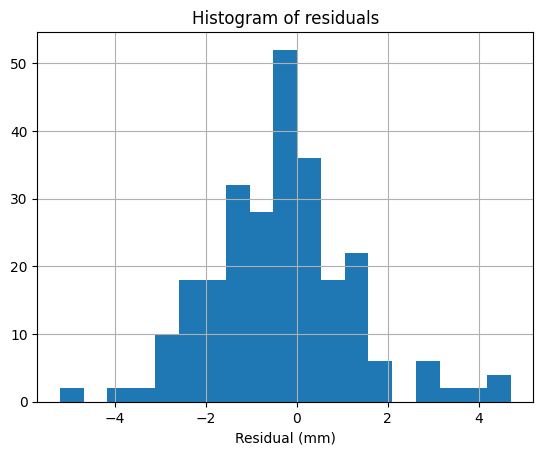

In [18]:
# ij resdual
ijres = m_ij_residual(res.x)
plt.hist(ijres, bins='fd');
plt.title("Histogram of residuals")
plt.xlabel("Residual (mm)")
plt.grid(True)
plt.savefig("residual_histogram.png")

The API expects 3D coordinates (with a z value which is zero in this case). Therefore we add a column of zeros.

In [19]:
absres = np.abs(ijres)
p95 = np.percentile(absres, 95)

print(f"95th percentile of residuals is {p95:4.2f} mm")
ijres_matrix = np.zeros_like(m_ij)
big_res = []
for r, i, j in zip(ijres, non_nan_indices[:,0], non_nan_indices[:,1]):
    if np.abs(r) > p95 and i > j:
        big_res.append([r,i,j])
    ijres_matrix[i,j] = r

for res in sorted(big_res):
    r,i,j = res
    print(f" res[{i},{j}] = {r:3.1f}")
    

95th percentile of residuals is 3.26 mm
 res[23,8] = -5.2
 res[21,4] = -3.7
 res[20,19] = 3.3
 res[23,4] = 3.7
 res[23,19] = 4.3
 res[23,7] = 4.7


## Output best estimates

Write some json files...

In [20]:
result = np.zeros((n_ant, 3))
result[:,:-1] = np.round(pos/1000.0, 3)
result

array([[ 0.059,  0.328,  0.   ],
       [ 0.307,  0.814,  0.   ],
       [ 0.636,  1.03 ,  0.   ],
       [ 0.966,  1.082,  0.   ],
       [ 1.287,  1.031,  0.   ],
       [ 0.333,  0.043,  0.   ],
       [ 0.871, -0.044,  0.   ],
       [ 1.174, -0.291,  0.   ],
       [ 1.328, -0.591,  0.   ],
       [ 1.378, -0.911,  0.   ],
       [ 0.143, -0.306,  0.   ],
       [ 0.227, -0.843,  0.   ],
       [ 0.086, -1.211,  0.   ],
       [-0.151, -1.448,  0.   ],
       [-0.442, -1.593,  0.   ],
       [-0.245, -0.232,  0.   ],
       [-0.729, -0.479,  0.   ],
       [-1.122, -0.46 ,  0.   ],
       [-1.422, -0.308,  0.   ],
       [-1.651, -0.08 ,  0.   ],
       [-0.294,  0.16 ,  0.   ],
       [-0.677,  0.545,  0.   ],
       [-0.778,  0.928,  0.   ],
       [-0.721,  1.259,  0.   ]])

In [21]:
json_result = {}
json_result["antenna_positions"] = result.tolist()

json_fname = f"{site_name}_processed_antenna_positions.json"
f = open(json_fname, "w")
f.write(json.dumps(json_result))
f.close()

pos_json = json.dumps(json_result, indent=4, separators=(',', ': '))
print(pos_json)

{
    "antenna_positions": [
        [
            0.059,
            0.328,
            0.0
        ],
        [
            0.307,
            0.814,
            0.0
        ],
        [
            0.636,
            1.03,
            0.0
        ],
        [
            0.966,
            1.082,
            0.0
        ],
        [
            1.287,
            1.031,
            0.0
        ],
        [
            0.333,
            0.043,
            0.0
        ],
        [
            0.871,
            -0.044,
            0.0
        ],
        [
            1.174,
            -0.291,
            0.0
        ],
        [
            1.328,
            -0.591,
            0.0
        ],
        [
            1.378,
            -0.911,
            0.0
        ],
        [
            0.143,
            -0.306,
            0.0
        ],
        [
            0.227,
            -0.843,
            0.0
        ],
        [
            0.086,
            -1.211,
            0.0
 

The position file above is in a format suitable for uploading to the telescope api. Also for using as the calibrated_antenna_positions.json file in TART/software/containers/telescope_web_api/config_data.


In [22]:
print(f"tart_upload_antenna_positions --api https://api.elec.ac.nz/tart/{site_name} --pw=xxxx --file {json_fname}")

tart_upload_antenna_positions --api https://api.elec.ac.nz/tart/nz-elec --pw=xxxx --file nz-elec_processed_antenna_positions.json
